# GRAPE for CNOT

In [1]:
# ruff: noqa
import os

os.sys.path.append("../../../..")

In [2]:
# ruff: noqa

"""
Gradient Ascent Pulse Engineering (GRAPE)
"""

import jax.numpy as jnp
import sys

from feedback_grape.grape import optimize_pulse, plot_control_amplitudes
from feedback_grape.utils.gates import cnot
from feedback_grape.utils.operators import identity, sigmax, sigmay, sigmaz
from feedback_grape.utils.tensor import tensor

g = 0.1  # Small coupling strength
H_drift = g * (tensor(sigmax(), sigmax()) + tensor(sigmay(), sigmay()))
H_ctrl = [
    tensor(sigmax(), identity(2)),
    tensor(sigmay(), identity(2)),
    tensor(sigmaz(), identity(2)),
    tensor(identity(2), sigmax()),
    tensor(identity(2), sigmay()),
    tensor(identity(2), sigmaz()),
    tensor(sigmax(), sigmax()),
    tensor(sigmay(), sigmay()),
    tensor(sigmaz(), sigmaz()),
]

U_0 = identity(4)
# Target operator (CNOT gate)
C_target = cnot()

num_t_slots = 500
total_evo_time = 2 * jnp.pi

# Run optimization
result = optimize_pulse(
    H_drift,
    H_ctrl,
    U_0,
    C_target,
    num_t_slots,
    total_evo_time,
    ctrl_amp_lower_bound=-2 * jnp.pi,
    ctrl_amp_upper_bound=2 * jnp.pi,
    evo_type="unitary",
    max_iter=100,
    learning_rate=1e-2,
    optimizer="l-bfgs",
)
print("final_fidelity: ", result.final_fidelity)
print("U_f \n", result.final_operator)
print("Converged after: ", result.iterations)

final_fidelity:  0.9999999999956259
U_f 
 [[ 7.07106607e-01-7.07106955e-01j  5.79698001e-07+1.99061591e-06j
  -6.26789035e-07-2.31726015e-07j -2.10989991e-07+1.64249706e-07j]
 [ 1.99061771e-06+5.79694566e-07j  7.07105737e-01-7.07107826e-01j
   2.41779595e-07+1.18286532e-06j  1.50326674e-07-6.92455949e-07j]
 [ 1.64248948e-07-2.10991188e-07j -6.92455453e-07+1.50328031e-07j
   2.95540397e-07+3.62808397e-08j  7.07107291e-01-7.07106271e-01j]
 [-2.31724782e-07-6.26786745e-07j  1.18286690e-06+2.41779050e-07j
   7.07107490e-01-7.07106073e-01j  3.62811664e-08+2.95540323e-07j]]
Converged after:  77


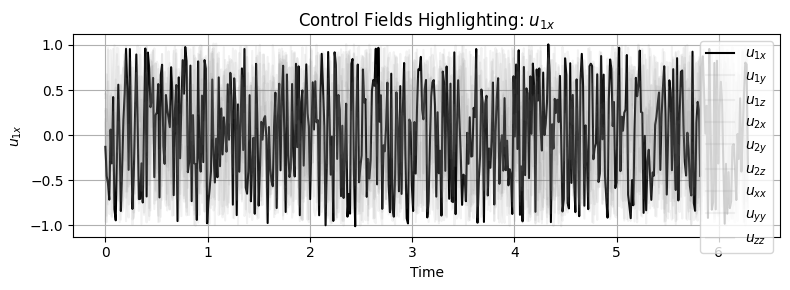

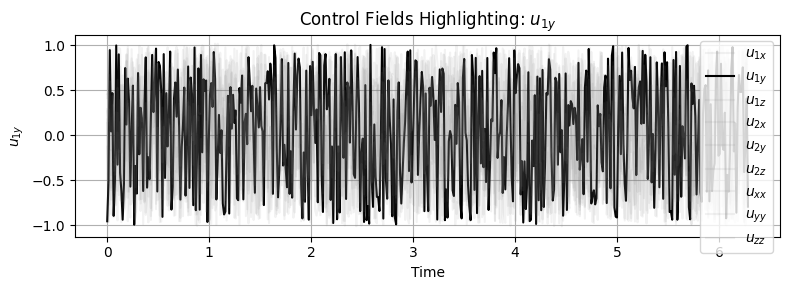

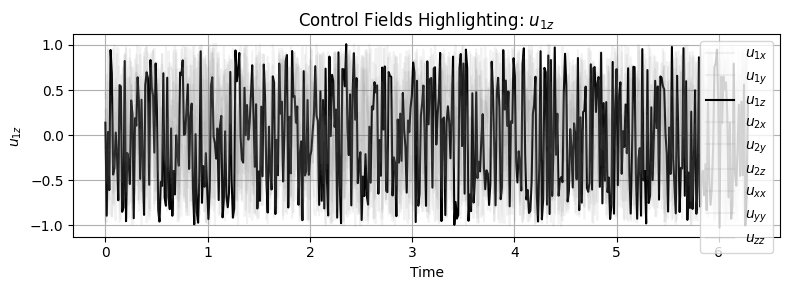

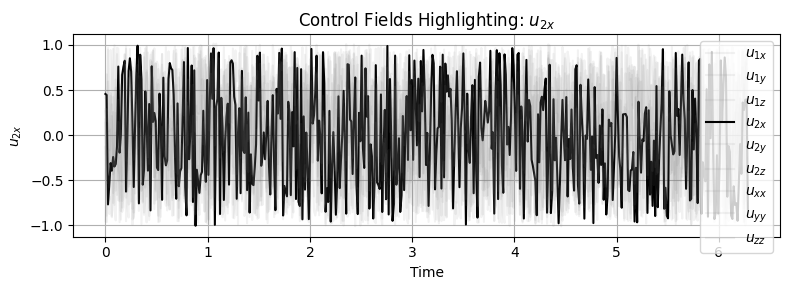

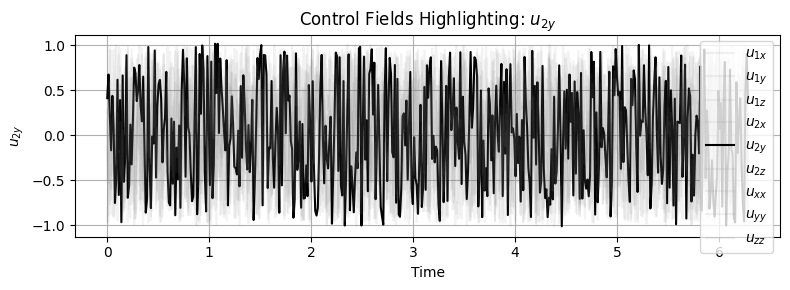

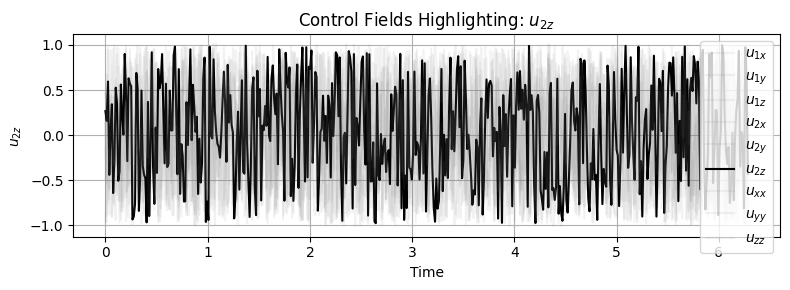

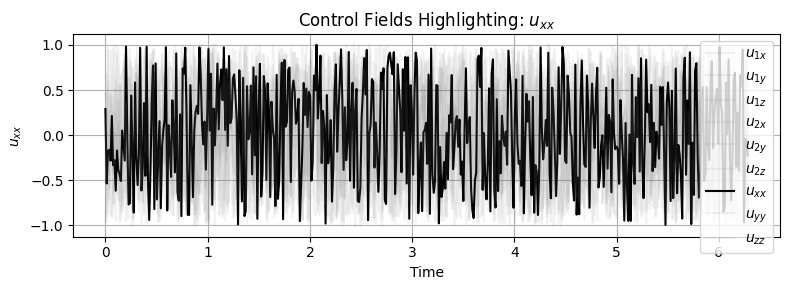

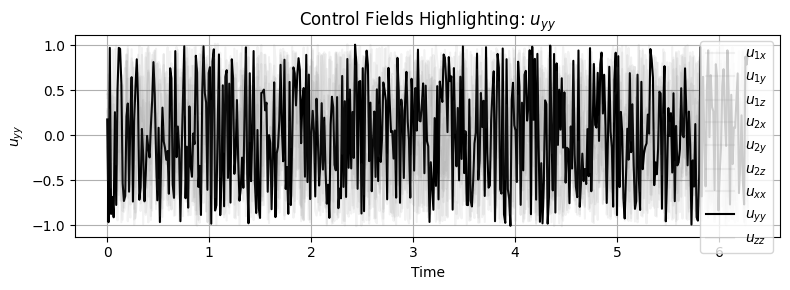

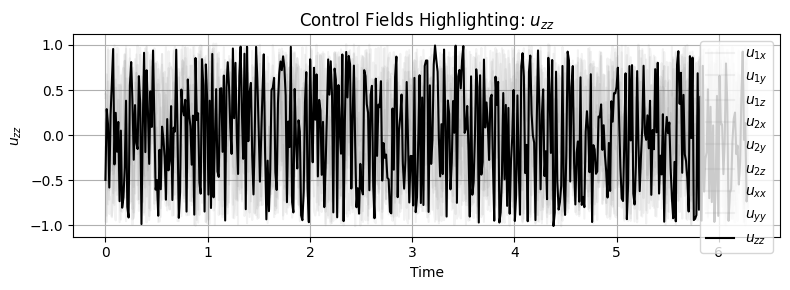

In [3]:
times = jnp.linspace(0, 2 * jnp.pi, 500)
H_labels = [
    r'$u_{1x}$',
    r'$u_{1y}$',
    r'$u_{1z}$',
    r'$u_{2x}$',
    r'$u_{2y}$',
    r'$u_{2z}$',
    r'$u_{xx}$',
    r'$u_{yy}$',
    r'$u_{zz}$',
]
plot_control_amplitudes(
    times, result.control_amplitudes / (2 * jnp.pi), H_labels
)

In [4]:
U_target = cnot()
U_f = result.final_operator

In [5]:
def overlap(U_target, U_f):
    """
    Calculate the overlap between the target unitary U_target and the final unitary U_f.

    Parameters:
    U_target (qutip.Qobj): Target unitary operator.
    U_f (qutip.Qobj): Final unitary operator.

    Returns:
    float: Real part of the overlap value.
    float: Fidelity (absolute square of the overlap).
    """
    # dividing over U_target.shape[0] is for normalization
    overlap_value = (
        jnp.trace(jnp.matmul(U_target.conj().T, U_f)) / U_target.shape[0]
    )
    fidelity = abs(overlap_value) ** 2
    return overlap_value.real, fidelity


# Example usage
overlap_real, fidelity = overlap(U_target, U_f)
print(f"Overlap (real part): {overlap_real}")
print(f"Fidelity: {fidelity}")

Overlap (real part): 0.7071067811850011
Fidelity: 0.9999999999956264
